In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
%pip install lightgbm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bd = pd.read_csv('/content/drive/My Drive/Hakaton/orders.csv', sep=',')
#bd # колво заказов по  зонам доставки 
bd

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2
...,...,...,...
884851,592,2021-11-30 16:00:00,6
884852,592,2021-11-30 17:00:00,3
884853,592,2021-11-30 18:00:00,2
884854,592,2021-11-30 19:00:00,4


In [ ]:
# указываем кол-во заказов  7 и 14 дней назад
bd = pd.concat([bd, bd['orders_cnt'].shift(7), bd['orders_cnt'].shift(14)], axis=1)
bd

In [ ]:
bd.columns= ['delivery_area_id', 'date','kol-vo-z', 'back_7d_z', 'back_14d_z'] # переименовываю столбцы
bd

In [6]:
#ДОБАВЛЯЮ СТОЛБЦЫ В  ТАБЛ
fast_ma=7
slow_ma=14
bd['target_sqrt'] = np.sqrt(bd['kol-vo-z'])                             # это два новых
bd['target_log'] = np.log(bd['kol-vo-z'])
bd['sred_za_7d']=bd['kol-vo-z'].rolling(window=fast_ma).mean()          #Средние колво заказов за 7 дней
bd['sred_za_14d']=bd['kol-vo-z'].rolling(window=slow_ma).mean()         #Средние колво заказов за 14 дней
bd['50%_sz7d+50%_sz14d'] = bd['sred_za_7d'] /2 + bd['sred_za_14d']/2    #сумма 50% от среднего за 7 дней и за 14 
bd=bd[14:]                                                              #убрал полученные нан значения от расчетов
bd

,delivery_area_id,date,kol-vo-z,back_7d_z,back_14d_z,target_sqrt,target_log,sred_za_7d,sred_za_14d,50%_sz7d+50%_sz14d
14,0,2021-04-02 14:00:00,3,2.0,9.0,1.732051,1.098612,2.142857,1.928571,2.035714
15,0,2021-04-02 15:00:00,1,2.0,1.0,1.000000,0.000000,2.000000,1.928571,1.964286
16,0,2021-04-02 17:00:00,1,1.0,1.0,1.000000,0.000000,2.000000,1.928571,1.964286
17,0,2021-04-02 18:00:00,2,3.0,1.0,1.414214,0.693147,1.857143,2.000000,1.928571
18,0,2021-04-02 19:00:00,3,1.0,2.0,1.732051,1.098612,2.142857,2.071429,2.107143
...,...,...,...,...,...,...,...,...,...,...
884851,592,2021-11-30 16:00:00,6,1.0,9.0,2.449490,1.791759,5.714286,5.000000,5.357143
884852,592,2021-11-30 17:00:00,3,10.0,4.0,1.732051,1.098612,4.714286,4.928571,4.821429
884853,592,2021-11-30 18:00:00,2,8.0,2.0,1.414214,0.693147,3.857143,4.928571,4.392857
884854,592,2021-11-30 19:00:00,4,8.0,5.0,2.000000,1.386294,3.285714,4.857143,4.071429


In [7]:
#это  используем  когда хотим  загруппировать  все значения часа за один день     код  в след ячейке ниже
bd['date'] = pd.to_datetime(bd['date'],errors='coerce') #  столбец date  преобразуем в дату 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from datetime import datetime
import time
bd['date'] = bd['date'].dt.strftime("%d%m%Y%H%M%S")


In [9]:
bd['date'] = bd['date'].astype(str)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bd

In [13]:
y = bd[['kol-vo-z']]
X = bd.drop(['kol-vo-z'], axis=1)

Линейная регрессия


In [14]:
# также зададим точку отсчета для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [15]:
# размерность обучающей
print(X_train.shape, y_train.shape)
 
# и тестовой выборки
print(X_test.shape, y_test.shape)

(707873, 9) (707873, 1)
(176969, 9) (176969, 1)


In [16]:
# создадим объект этого класса и запишем в переменную model
model = LinearRegression()
 
# обучим нашу модель
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# на основе нескольких независимых переменных (Х) предскажем цену на жилье (y)
y_pred = model.predict(X_test)
 
# выведем первые пять значений с помощью диапазона индексов
print(y_pred[:5])
print(X_test[:5])

In [ ]:
X_test.shape

(176969, 9)

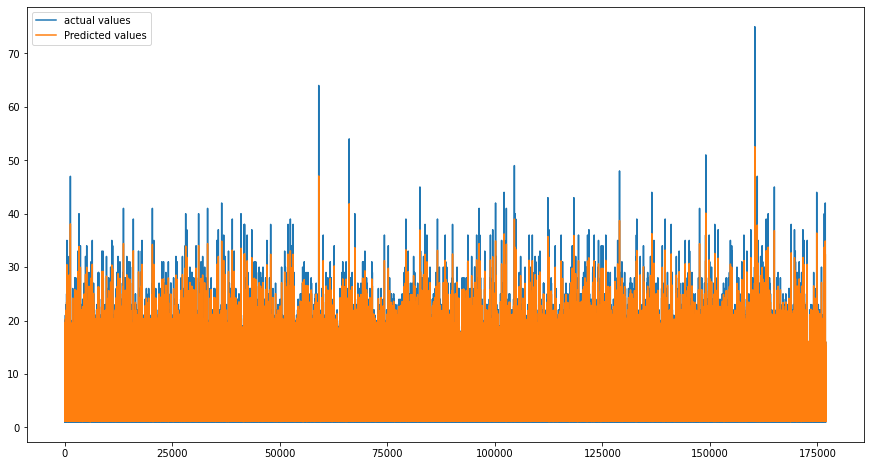

In [20]:
import matplotlib.pyplot as plt

# fitting the size of the plot
plt.figure(figsize=(15, 8))

# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values")

# showing the plotting
plt.legend()
plt.show()

In [19]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print(' RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2: 0.99
MAE: 0.22570352880096317
 RMSE: 0.320420098769843


LightGBM

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [ ]:
X_train.dtypes

In [38]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
X_train['date'] = lbl.fit_transform(X_train['date'].astype(str))
X_test['date'] = lbl.fit_transform(X_test['date'].astype(str))

In [39]:
import lightgbm as lgb

# initialzing the model
model = lgb.LGBMRegressor()

# train the model
model.fit(X_train,y_train)

LGBMRegressor()

In [31]:
lightR_predict = model.predict(X_test)

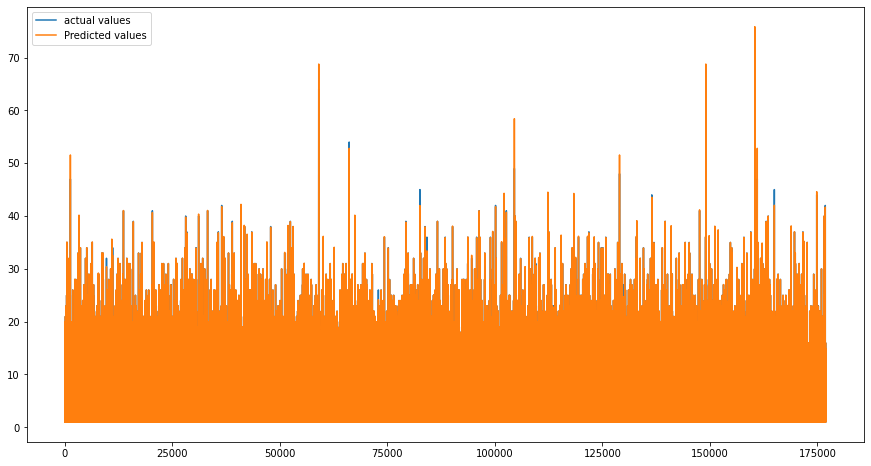

In [32]:
import matplotlib.pyplot as plt

# fitting the size of the plot
plt.figure(figsize=(15, 8))

# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],lightR_predict, label="Predicted values")

# showing the plotting
plt.legend()
plt.show()

In [34]:
print('R2:', np.round(metrics.r2_score(y_test, lightR_predict), 2))
print('MAE:',metrics.mean_absolute_error(y_test, lightR_predict))
print(' RMSE:', np.sqrt(metrics.mean_squared_error(y_test,lightR_predict)))

R2: 1.0
MAE: 0.0007679333963100712
 RMSE: 0.05670154971300339
